<a href="https://colab.research.google.com/github/HuyenTrang457/OLP/blob/main/model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.3.1
Uninstalling scikit-learn-1.3.1:
  Successfully uninstalled scikit-learn-1.3.1
  Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from scipy.stats import f_oneway, chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd
import numpy as np

In [ ]:

# Load the uploaded file
file_name = '/content/drive/MyDrive/MCM_data/data_train.xlsx'
df = pd.read_excel(file_name)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# Đảm bảo 'df' đã được định nghĩa trước đó

# Kiểm tra và chuyển đổi các cột
df['Year'] = df['Year'].astype(int)  # Chuyển cột 'Year' sang kiểu số nguyên
df['Continent'] = df['Continent'].astype(str)  # Đảm bảo 'Continent' là kiểu chuỗi
df['Is_Host'] = df['Is_Host'].astype(int)  # Chuyển đổi 'Is_Host' sang kiểu số nguyên

# Kiểm tra giá trị nhỏ nhất trong cột 'Distance_To_Host'
min_value = df['Distance_To_Host'].min()

# Nếu có giá trị âm hoặc 0, dịch dữ liệu lên một hằng số dương
if min_value <= 0:
    offset = abs(min_value) + 1  # Thêm hằng số để đảm bảo tất cả giá trị > 0
    df['Distance_To_Host'] = df['Distance_To_Host'] + offset

# Áp dụng Log Transformation
df['Distance_To_Host_Log'] = np.log1p(df['Distance_To_Host'])  # log(x + 1)

# Xóa cột 'Distance_To_Host' gốc
df = df.drop(columns=['Distance_To_Host'])

# Áp dụng OneHotEncoder cho cột 'Continent'
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(df[['Continent','NOC']])  # Mã hóa 'Continent'
all_feature_names = encoder.get_feature_names_out(['Continent','NOC'])

# If you need feature names only for NOC:
noc_columns = [col for col in all_feature_names if col.startswith('NOC_')]
# Tạo DataFrame từ dữ liệu mã hóa
encoded_columns_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Continent','NOC']))

# Xóa các cột không cần thiết
processed_df = df.drop(columns=['Continent', 'Rank', 'Team', 'NOC'], errors='ignore')

# Kết hợp dữ liệu mã hóa với DataFrame gốc
final_df = pd.concat([processed_df, encoded_columns_df], axis=1)

# Hiển thị DataFrame cuối cùng
print(final_df.head())


   Year  Gold  Silver  Bronze  Total  Is_Host  Participation_Score  \
0  1896     2       0       0      2        0             1.346918   
1  1896     0       0       0      0        0             0.277259   
2  1896     2       1       2      5        0             1.360479   
3  1896     1       2       3      6        0             1.360479   
4  1896     5       4       2     11        0             1.373595   

   Medal_Score  Medals_lag_1  Athlete_Ratio_Among_Countries  ...  NOC_VIN  \
0          0.3             0                       0.010526  ...      0.0   
1          0.3             0                       0.005263  ...      0.0   
2          0.3             0                       0.021053  ...      0.0   
3          0.3             0                       0.039474  ...      0.0   
4          0.3             0                       0.068421  ...      0.0   

   NOC_VIR  NOC_VNM  NOC_VUT  NOC_WSM  NOC_YEM  NOC_YUG  NOC_ZAF  NOC_ZMB  \
0      0.0      0.0      0.0      0.0  

In [ ]:

numerical_features = [
    "Year", "Gold", "Silver", "Bronze", "Total",
    "Participation_Score", "Medal_Score", "Medals_lag_1",
    "Athlete_Ratio_Among_Countries", "Athlete_Medal_Ratio",
    "Total_Events_Participated", "Total_Sports_Participated",
    "Medal_Winning_Percentage_Per_Event", "Medal_Winning_Percentage_Per_Sport",
    "Total_Events", "Total_Sports", "Repeat_Participant_Ratio",
    "Distance_To_Host_Log"
]
categorical_features= [feature for feature in final_df if feature not in numerical_features]


In [ ]:
# 2. Định danh loại feature


print("Feature dạng số:", numerical_features)
print("Feature dạng phân loại:", categorical_features)

# Tách feature và target (giả sử cột cuối là target)
target_columns = ['Gold', 'Silver', 'Bronze', 'Total']
X = df.drop(columns=target_columns)  # Các feature
y = df[target_columns]

Feature dạng số: ['Year', 'Gold', 'Silver', 'Bronze', 'Total', 'Participation_Score', 'Medal_Score', 'Medals_lag_1', 'Athlete_Ratio_Among_Countries', 'Athlete_Medal_Ratio', 'Total_Events_Participated', 'Total_Sports_Participated', 'Medal_Winning_Percentage_Per_Event', 'Medal_Winning_Percentage_Per_Sport', 'Total_Events', 'Total_Sports', 'Repeat_Participant_Ratio', 'Distance_To_Host_Log']
Feature dạng phân loại: ['Is_Host', 'Is_Neighbor', 'Number_Of_Medals_Per_Continent', 'Continent_Africa', 'Continent_Asia', 'Continent_Europe', 'Continent_North America', 'Continent_Oceania', 'Continent_South America', 'NOC_AAM', 'NOC_AFG', 'NOC_AGO', 'NOC_AHO', 'NOC_ALB', 'NOC_AND', 'NOC_ANZ', 'NOC_ARE', 'NOC_ARG', 'NOC_ARM', 'NOC_ARU', 'NOC_ASA', 'NOC_ATG', 'NOC_AUS', 'NOC_AUS/GBR', 'NOC_AUT', 'NOC_AZE', 'NOC_BDI', 'NOC_BEL', 'NOC_BEN', 'NOC_BER', 'NOC_BFA', 'NOC_BGD', 'NOC_BGR', 'NOC_BHR', 'NOC_BHS', 'NOC_BIH', 'NOC_BLR', 'NOC_BLZ', 'NOC_BOH', 'NOC_BOL', 'NOC_BRA', 'NOC_BRB', 'NOC_BRN', 'NOC_BRU', 'N

data kiểm định

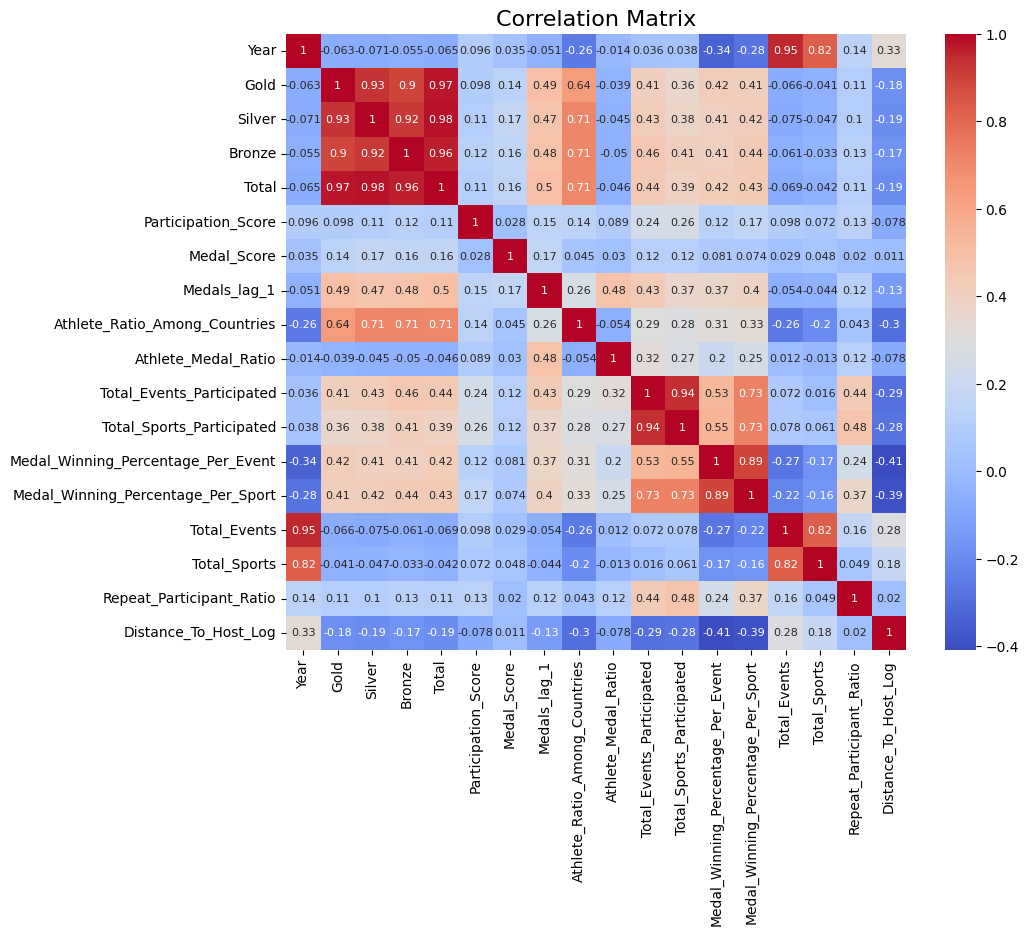

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo ma trận tương quan chỉ với các feature dạng số
correlation_matrix = final_df[numerical_features].corr()

# Trực quan hóa ma trận tương quan với heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 8})  # Giảm kích thước font chữ
plt.title('Correlation Matrix', fontsize=16)  # Tăng font chữ tiêu đề nếu cần
plt.show()


In [ ]:
final_df = final_df.drop(columns=['Total','Medal_Winning_Percentage_Per_Sport', 'Total_Sports_Participated'])



In [ ]:

numerical_features = [
    "Year", "Gold", "Silver", "Bronze",
    "Participation_Score", "Medal_Score", "Medals_lag_1",
    "Athlete_Ratio_Among_Countries", "Athlete_Medal_Ratio",
    "Total_Events_Participated",
    "Medal_Winning_Percentage_Per_Event",
    "Total_Events", "Total_Sports", "Repeat_Participant_Ratio",
    "Distance_To_Host_Log"
]
categorical_features= [feature for feature in final_df if feature not in numerical_features]


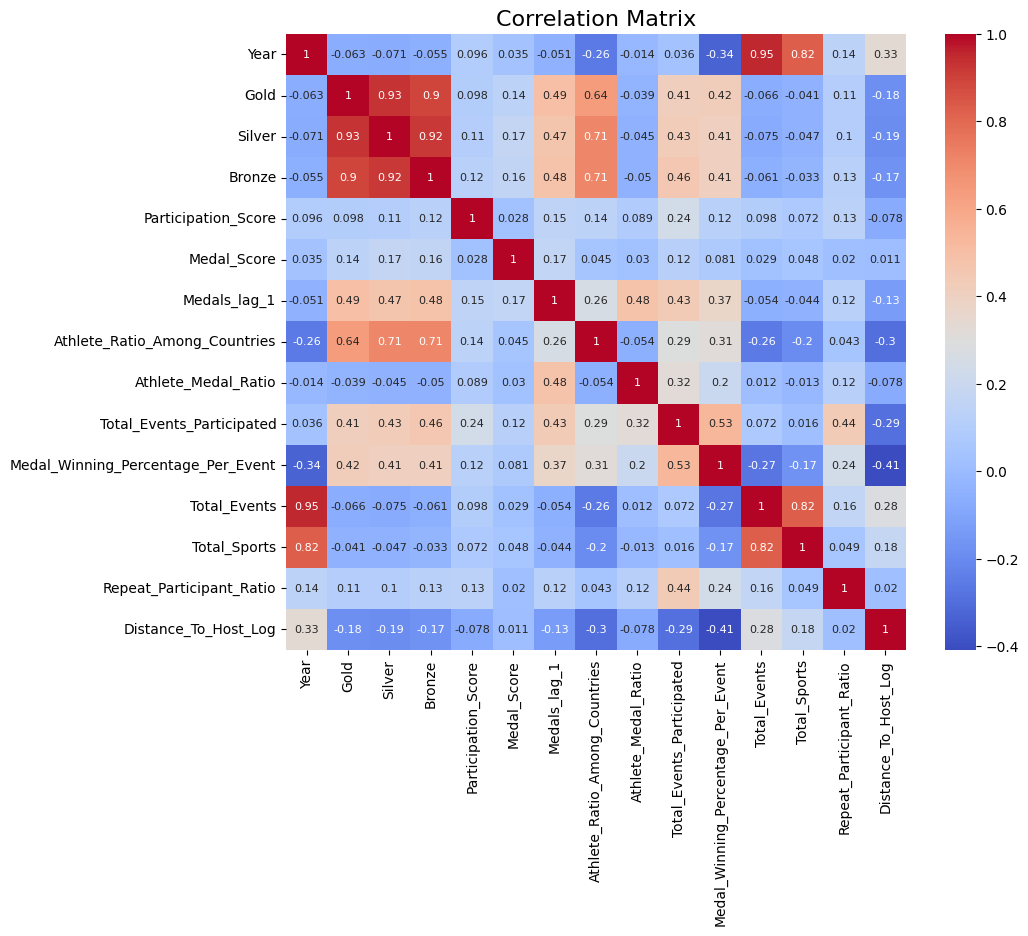

In [ ]:
correlation_matrix = final_df[numerical_features].corr()

# Trực quan hóa ma trận tương quan với heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 8})  # Giảm kích thước font chữ
plt.title('Correlation Matrix', fontsize=16)  # Tăng font chữ tiêu đề nếu cần
plt.show()

VIF

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler

# Đọc dữ liệu từ file
df= final_df[numerical_features]


# Kiểm tra lại xem còn giá trị NaN hoặc vô hạn không
if df.isna().sum().sum() > 0:
    print("Vẫn còn giá trị NaN trong dữ liệu!")
if np.isinf(df).sum().sum() > 0:
    print("Vẫn còn giá trị vô hạn trong dữ liệu!")

# Lọc các cột số (numerical columns)

# Chuẩn bị dữ liệu cho tính VIF
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)  # Chuẩn hóa dữ liệu
print(X_scaled)
# Thêm hệ số chặn (constant) vào dữ liệu
X_scaled_with_const = add_constant(X_scaled)

# Tính VIF cho từng biến
vif = pd.DataFrame()
vif['Variable'] = ['const'] + df.columns.tolist()  # Thêm tên cột vào danh sách
vif['VIF'] = [variance_inflation_factor(X_scaled_with_const, i) for i in range(X_scaled_with_const.shape[1])]

# Hiển thị kết quả
print(vif)

# Lưu kết quả VIF vào file CSV
vif.to_csv('vif_results.csv', index=False)


[[-2.79937125  0.07829056 -0.32206906 ... -2.3872855  -1.13986443
   0.69048614]
 [-2.79937125 -0.2803276  -0.32206906 ... -2.3872855  -1.13986443
   0.69048614]
 [-2.79937125  0.07829056 -0.11509643 ... -2.3872855   0.05743491
  -1.01789172]
 ...
 [ 1.19512331 -0.2803276  -0.32206906 ...  2.33147778 -1.13986443
   0.07511488]
 [ 1.19512331 -0.2803276  -0.32206906 ...  2.33147778 -1.13986443
   0.24916206]
 [ 1.19512331 -0.2803276  -0.32206906 ...  2.33147778 -1.13986443
   0.30970857]]
                              Variable        VIF
0                                const   1.000000
1                                 Year  13.897909
2                                 Gold   8.539038
3                               Silver  11.607276
4                               Bronze   8.292548
5                  Participation_Score   1.096465
6                          Medal_Score   1.063368
7                         Medals_lag_1   2.141122
8        Athlete_Ratio_Among_Countries   2.624132
9       

In [ ]:
print(final_df.columns)


Index(['Year', 'Gold', 'Silver', 'Bronze', 'Is_Host', 'Participation_Score',
       'Medal_Score', 'Medals_lag_1', 'Athlete_Ratio_Among_Countries',
       'Athlete_Medal_Ratio',
       ...
       'NOC_VIN', 'NOC_VIR', 'NOC_VNM', 'NOC_VUT', 'NOC_WSM', 'NOC_YEM',
       'NOC_YUG', 'NOC_ZAF', 'NOC_ZMB', 'NOC_ZWE'],
      dtype='object', length=279)


In [ ]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# Chia tập dữ liệu thành Train và Test
target_columns = ['Gold', 'Silver', 'Bronze']
X = final_df.drop(columns=target_columns)  # Các feature
y = final_df[target_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kiểm tra kích thước của dữ liệu
print("Kích thước X_train:", X_train.shape)
print("Kích thước y_train:", y_train.shape)
print("Kích thước X_test:", X_test.shape)
print("Kích thước y_test:", y_test.shape)

Kích thước X_train: (2966, 276)
Kích thước y_train: (2966, 3)
Kích thước X_test: (742, 276)
Kích thước y_test: (742, 3)


Thử nghiệm trên XGBoost

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    "Support Vector Regression": MultiOutputRegressor(SVR(kernel='rbf'))
}

# Store results
results = []

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')

    # Append results
    results.append({
        "Model": name,
        "MSE_Gold": mse[0],
        "MSE_Silver": mse[1],
        "MSE_Bronze": mse[2],
        "RMSE_Gold": rmse[0],
        "RMSE_Silver": rmse[1],
        "RMSE_Bronze": rmse[2],
        "R2_Gold": r2[0],
        "R2_Silver": r2[1],
        "R2_Bronze": r2[2]
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.28212e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


                       Model   MSE_Gold  MSE_Silver  MSE_Bronze  RMSE_Gold  \
0          Linear Regression   9.333247    7.519451    6.522008   3.055036   
1           Ridge Regression  10.968127    9.079096    7.827909   3.311816   
2           Lasso Regression  10.377386    8.791070    7.253859   3.221395   
3              Random Forest   2.211294    2.023722    2.249055   1.487042   
4  Support Vector Regression  31.264688   23.794002   24.316837   5.591484   

   RMSE_Silver  RMSE_Bronze   R2_Gold  R2_Silver  R2_Bronze  
0     2.742162     2.553822  0.675458   0.651122   0.696627  
1     3.013154     2.797840  0.618608   0.578760   0.635883  
2     2.964974     2.693299  0.639150   0.592123   0.662585  
3     1.422576     1.499685  0.923107   0.906106   0.895385  
4     4.877910     4.931210 -0.087158  -0.103963  -0.131104  


In [ ]:
print("Kích thước X_train:", X_train.shape)
print("Kích thước y_train:", y_train.shape)
print("Kích thước X_test:", X_test.shape)
print("Kích thước y_test:", y_test.shape)

Kích thước X_train: (2966, 276)
Kích thước y_train: (2966, 3)
Kích thước X_test: (742, 276)
Kích thước y_test: (742, 3)


In [ ]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
# Chuyển đổi Year thành số nguyên

# Khởi tạo mô hình XGBoost
xgb_model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42))

# Huấn luyện mô hình
xgb_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_xgb = xgb_model.predict(X_test)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
y_pred_xgb = xgb_model.predict(X_test)
# Tính các chỉ số
mae = mean_absolute_error(y_test, y_pred_xgb, multioutput='raw_values')
mse = mean_squared_error(y_test, y_pred_xgb, multioutput='raw_values')
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb, multioutput='raw_values')

# Hiển thị kết quả
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): [0.70959699 0.67872903 0.73292597]
Mean Squared Error (MSE): [3.20374571 2.51036772 2.72841817]
Root Mean Squared Error (RMSE): [1.78990103 1.584414   1.65179241]
R-squared (R²): [0.88859708 0.8835272  0.8730869 ]


In [ ]:
from sklearn.model_selection import GridSearchCV

# Định nghĩa lưới tham số
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7],
    'estimator__subsample': [0.8, 1.0],
    'estimator__colsample_bytree': [0.8, 1.0]
}

# GridSearchCV cho XGBoost
grid_search_xgb = GridSearchCV(
    MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42)),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Huấn luyện
grid_search_xgb.fit(X_train, y_train)

# Tham số tốt nhất
print("Best Parameters:", grid_search_xgb.best_params_)

# Mô hình tốt nhất
best_xgb_model = grid_search_xgb.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'estimator__colsample_bytree': 1.0, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 7, 'estimator__n_estimators': 100, 'estimator__subsample': 0.8}


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
expected_feature_names = best_xgb_model.estimators_[0].get_booster().feature_names

# Ensure X_test has the same columns in the same order
X_test = X_test[expected_feature_names]
y_pred_xgb1 = best_xgb_model.predict(X_test)
# Tính các chỉ số
mae = mean_absolute_error(y_test, y_pred_xgb1, multioutput='raw_values')
mse = mean_squared_error(y_test, y_pred_xgb1, multioutput='raw_values')
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb1, multioutput='raw_values')

# Hiển thị kết quả
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): [0.68963589 0.63813407 0.71836526]
Mean Squared Error (MSE): [3.63967451 2.35765416 2.75910269]
Root Mean Squared Error (RMSE): [1.9077931  1.53546545 1.66105469]
R-squared (R²): [0.87343865 0.89061261 0.8716596 ]


In [ ]:
print("Columns in X_train:", list(X_train.columns))
print("Columns in X_test:", list(X_test.columns))


Columns in X_train: ['Year', 'Is_Host', 'Participation_Score', 'Medal_Score', 'Medals_lag_1', 'Athlete_Ratio_Among_Countries', 'Athlete_Medal_Ratio', 'Total_Events_Participated', 'Medal_Winning_Percentage_Per_Event', 'Total_Events', 'Total_Sports', 'Repeat_Participant_Ratio', 'Is_Neighbor', 'Number_Of_Medals_Per_Continent', 'Distance_To_Host_Log', 'Continent_Africa', 'Continent_Asia', 'Continent_Europe', 'Continent_North America', 'Continent_Oceania', 'Continent_South America', 'NOC_AAM', 'NOC_AFG', 'NOC_AGO', 'NOC_AHO', 'NOC_ALB', 'NOC_AND', 'NOC_ANZ', 'NOC_ARE', 'NOC_ARG', 'NOC_ARM', 'NOC_ARU', 'NOC_ASA', 'NOC_ATG', 'NOC_AUS', 'NOC_AUS/GBR', 'NOC_AUT', 'NOC_AZE', 'NOC_BDI', 'NOC_BEL', 'NOC_BEN', 'NOC_BER', 'NOC_BFA', 'NOC_BGD', 'NOC_BGR', 'NOC_BHR', 'NOC_BHS', 'NOC_BIH', 'NOC_BLR', 'NOC_BLZ', 'NOC_BOH', 'NOC_BOL', 'NOC_BRA', 'NOC_BRB', 'NOC_BRN', 'NOC_BRU', 'NOC_BTN', 'NOC_BUL', 'NOC_BWA', 'NOC_BWI', 'NOC_CAF', 'NOC_CAN', 'NOC_CAY', 'NOC_CEY', 'NOC_CGO', 'NOC_CHE', 'NOC_CHL', 'NOC_CH

In [ ]:
import pandas as pd

# Danh sách để lưu tầm quan trọng của các feature từ từng mô hình con
feature_importances_list = []

# Lặp qua các mô hình con trong best_xgb_model
for i, estimator in enumerate(best_xgb_model.estimators_):
    feature_importances = estimator.feature_importances_  # Trích xuất feature_importances từ mô hình con
    feature_importances_list.append(pd.DataFrame({
        'Feature': X_train.columns,  # Tên các feature
        f'Importance_Target_{i}': feature_importances  # Tầm quan trọng cho từng target
    }))

# Gộp tất cả các tầm quan trọng vào một DataFrame
feature_importances_xgb = pd.concat(feature_importances_list, axis=1)

# Gộp các cột "Feature" lại duy nhất
feature_importances_xgb = feature_importances_xgb.loc[:, ~feature_importances_xgb.columns.duplicated()]

# Tính tầm quan trọng trung bình
feature_importances_xgb['Average_Importance'] = feature_importances_xgb.iloc[:, 1:].mean(axis=1)

# Sắp xếp theo tầm quan trọng trung bình
feature_importances_xgb = feature_importances_xgb.sort_values(by='Average_Importance', ascending=False)

# Xuất kết quả
print("Feature Importances Summary (kèm theo trung bình):")

# Nếu cần lưu ra file CSV
# feature_importances_df.to_csv('feature_importance_summary.csv', index=False)


Feature Importances Summary (kèm theo trung bình):


In [ ]:
# Huấn luyện mô hình Random Forest
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
y_pred_rf = rf_model.predict(X_test)
# Tính các chỉ số
mae = mean_absolute_error(y_test, y_pred_rf, multioutput='raw_values')
mse = mean_squared_error(y_test, y_pred_rf, multioutput='raw_values')
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf, multioutput='raw_values')

# Hiển thị kết quả
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): [0.60691375 0.61814016 0.67764151]
Mean Squared Error (MSE): [2.48756132 2.02666765 2.38405593]
Root Mean Squared Error (RMSE): [1.57720047 1.42361078 1.54403884]
R-squared (R²): [0.91350075 0.90596929 0.889105  ]


In [ ]:
# Trích xuất độ quan trọng
rf_feature_importances = rf_model.feature_importances_

# Tạo DataFrame cho kết quả
rf_importances_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf_feature_importances
}).sort_values(by="Importance", ascending=False)

print("Random Forest Feature Importances:")
print(rf_importances_df)

Random Forest Feature Importances:
                                Feature  Importance
5         Athlete_Ratio_Among_Countries    0.504885
8    Medal_Winning_Percentage_Per_Event    0.243808
7             Total_Events_Participated    0.087870
4                          Medals_lag_1    0.039274
3                           Medal_Score    0.019592
..                                  ...         ...
160                             NOC_LKA    0.000000
159                             NOC_LIE    0.000000
157                             NOC_LBY    0.000000
156                             NOC_LBR    0.000000
47                              NOC_BIH    0.000000

[276 rows x 2 columns]


<Figure size 2000x600 with 0 Axes>

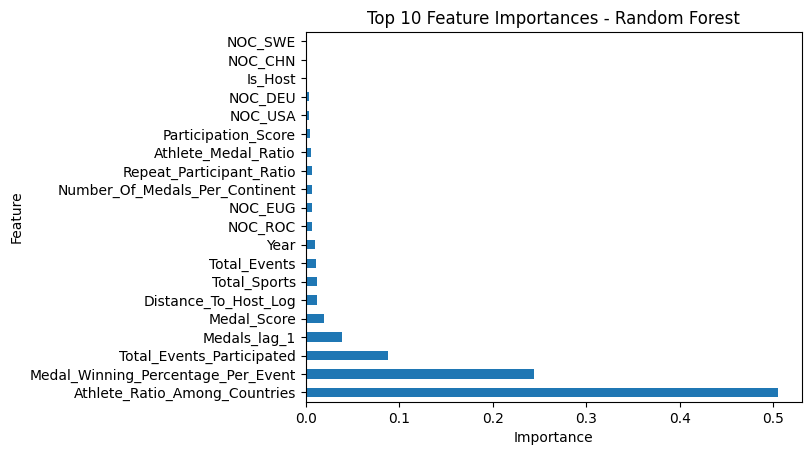

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.figure(figsize=(20, 6))
rf_importances_df.sort_values(by="Importance", ascending=False).head(20).plot(
    kind="barh", x="Feature", y="Importance", legend=False)
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


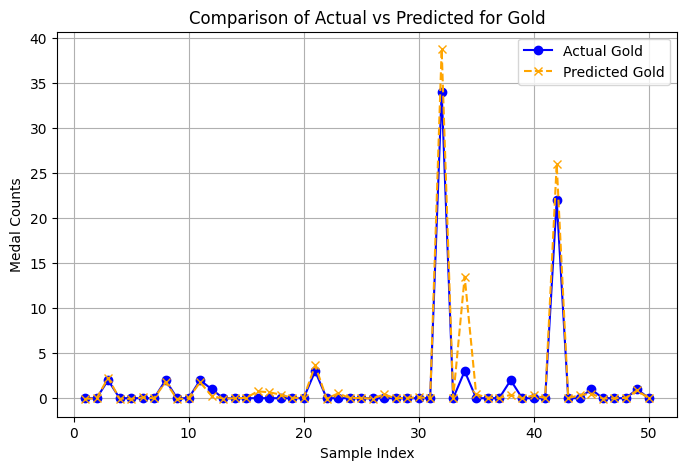

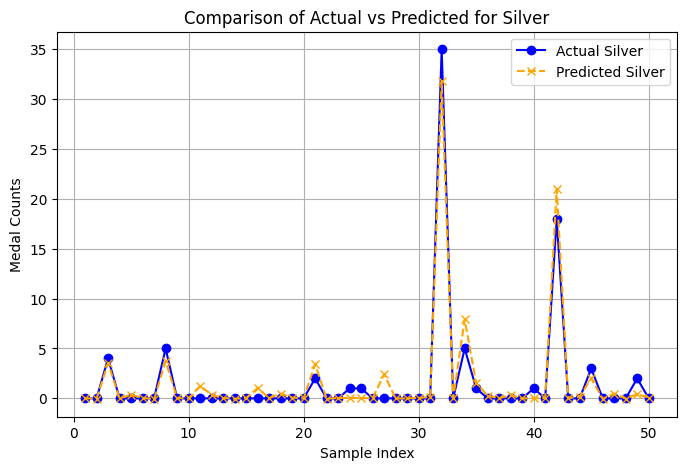

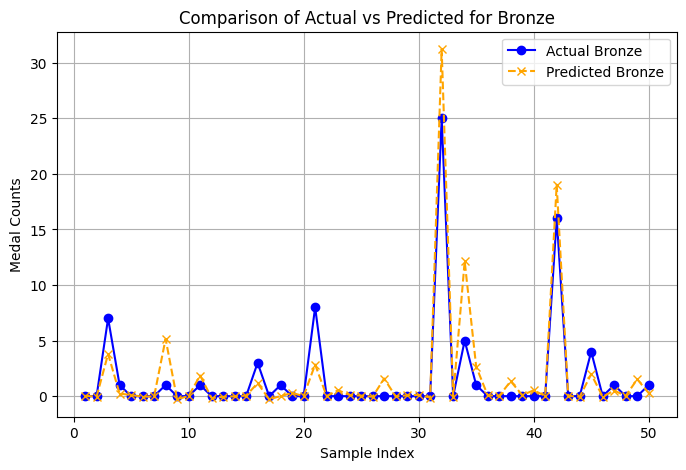

In [ ]:
import matplotlib.pyplot as plt
y_pred_rf = rf_model.predict(X_test)

# Chọn 10 mẫu đầu tiên từ tập kiểm tra để trực quan hóa
y_actual = y_test.iloc[:50].values  # Giá trị thực tế
y_pred = y_pred_xgb[:50]  # Giá trị dự đoán

# Tạo các biểu đồ đường riêng cho từng loại huy chương
categories = ['Gold', 'Silver', 'Bronze']
x = range(1, len(y_actual) + 1)  # Số thứ tự mẫu

for i, category in enumerate(categories):
    plt.figure(figsize=(8, 5))
    plt.plot(x, y_actual[:, i], marker='o', label=f'Actual {category}', color='blue')
    plt.plot(x, y_pred[:, i], marker='x', linestyle='--', label=f'Predicted {category}', color='orange')
    plt.xlabel('Sample Index')
    plt.ylabel('Medal Counts')
    plt.title(f'Comparison of Actual vs Predicted for {category}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
y_pred_xgb =best_xgb_model.predict(X_test)
# Tính toán các chỉ số hiệu suất
metrics = {
    "Model": ["XGBoost"],
    "MSE_Gold": [mean_squared_error(y_test.iloc[:, 0], y_pred_xgb[:, 0])],
    "MSE_Silver": [mean_squared_error(y_test.iloc[:, 1], y_pred_xgb[:, 1])],
    "MSE_Bronze": [mean_squared_error(y_test.iloc[:, 2], y_pred_xgb[:, 2])],
    "RMSE_Gold": [np.sqrt(mean_squared_error(y_test.iloc[:, 0], y_pred_xgb[:, 0]))],
    "RMSE_Silver": [np.sqrt(mean_squared_error(y_test.iloc[:, 1], y_pred_xgb[:, 1]))],
    "RMSE_Bronze": [np.sqrt(mean_squared_error(y_test.iloc[:, 2], y_pred_xgb[:, 2]))],
    "MAE_Gold": [mean_absolute_error(y_test.iloc[:, 0], y_pred_xgb[:, 0])],
    "MAE_Silver": [mean_absolute_error(y_test.iloc[:, 1], y_pred_xgb[:, 1])],
    "MAE_Bronze": [mean_absolute_error(y_test.iloc[:, 2], y_pred_xgb[:, 2])],
    "R2_Gold": [r2_score(y_test.iloc[:, 0], y_pred_xgb[:, 0])],
    "R2_Silver": [r2_score(y_test.iloc[:, 1], y_pred_xgb[:, 1])],
    "R2_Bronze": [r2_score(y_test.iloc[:, 2], y_pred_xgb[:, 2])]
}

# Tạo DataFrame để hiển thị kết quả
performance_df = pd.DataFrame(metrics)
print(performance_df)
# Hiển thị bảng kết quả

     Model  MSE_Gold  MSE_Silver  MSE_Bronze  RMSE_Gold  RMSE_Silver  \
0  XGBoost  3.639675    2.357654    2.759103   1.907793     1.535465   

   RMSE_Bronze  MAE_Gold  MAE_Silver  MAE_Bronze   R2_Gold  R2_Silver  \
0     1.661055  0.689636    0.638134    0.718365  0.873439   0.890613   

   R2_Bronze  
0    0.87166  


In [ ]:
y_pred_rf = rf_model.predict(X_test)

# Tính toán các chỉ số hiệu suất cho Random Forest
rf_metrics = {
    "Model": ["Random Forest"],
    "MSE_Gold": [mean_squared_error(y_test.iloc[:, 0], y_pred_rf[:, 0])],
    "MSE_Silver": [mean_squared_error(y_test.iloc[:, 1], y_pred_rf[:, 1])],
    "MSE_Bronze": [mean_squared_error(y_test.iloc[:, 2], y_pred_rf[:, 2])],
    "RMSE_Gold": [np.sqrt(mean_squared_error(y_test.iloc[:, 0], y_pred_rf[:, 0]))],
    "RMSE_Silver": [np.sqrt(mean_squared_error(y_test.iloc[:, 1], y_pred_rf[:, 1]))],
    "RMSE_Bronze": [np.sqrt(mean_squared_error(y_test.iloc[:, 2], y_pred_rf[:, 2]))],
    "MAE_Gold": [mean_absolute_error(y_test.iloc[:, 0], y_pred_rf[:, 0])],
    "MAE_Silver": [mean_absolute_error(y_test.iloc[:, 1], y_pred_rf[:, 1])],
    "MAE_Bronze": [mean_absolute_error(y_test.iloc[:, 2], y_pred_rf[:, 2])],
    "R2_Gold": [r2_score(y_test.iloc[:, 0], y_pred_rf[:, 0])],
    "R2_Silver": [r2_score(y_test.iloc[:, 1], y_pred_rf[:, 1])],
    "R2_Bronze": [r2_score(y_test.iloc[:, 2], y_pred_rf[:, 2])]
}

# Kết hợp kết quả của cả XGBoost và Random Forest
combined_metrics_df = pd.concat(
    [performance_df, pd.DataFrame(rf_metrics)],
    ignore_index=True
)
print(combined_metrics_df)

           Model  MSE_Gold  MSE_Silver  MSE_Bronze  RMSE_Gold  RMSE_Silver  \
0        XGBoost  3.639675    2.357654    2.759103   1.907793     1.535465   
1  Random Forest  2.487561    2.026668    2.384056   1.577200     1.423611   

   RMSE_Bronze  MAE_Gold  MAE_Silver  MAE_Bronze   R2_Gold  R2_Silver  \
0     1.661055  0.689636    0.638134    0.718365  0.873439   0.890613   
1     1.544039  0.606914    0.618140    0.677642  0.913501   0.905969   

   R2_Bronze  
0   0.871660  
1   0.889105  


Random Forest vượt trội hơn XGBoost trong cả ba hạng mục (Gold, Silver, Bronze) về các chỉ số MSE, RMSE, MAE và R².

# Thử nghiệm trên LightGBM

In [ ]:
from lightgbm import LGBMRegressor

# Khởi tạo mô hình LightGBM
lgb_model = MultiOutputRegressor(LGBMRegressor(random_state=42))

# Huấn luyện mô hình
lgb_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_lgb = lgb_model.predict(X_test)

# Đánh giá hiệu suất
mse_lgb = mean_squared_error(y_test, y_pred_lgb, multioutput='raw_values')
print("LightGBM - Mean Squared Error (MSE):", mse_lgb)


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 2966, number of used features: 56
[LightGBM] [Info] Start training from score 1.533378
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 2966, number of used features: 56
[LightGBM] [Info] Start training from score 1.545853
[LightGBM] [Warning] Found whi

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor

# Định nghĩa lưới tham số
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7],
    'estimator__subsample': [0.8, 1.0],
    'estimator__colsample_bytree': [0.8, 1.0]
}

# Khởi tạo mô hình LightGBM với MultiOutputRegressor
lgb_model = MultiOutputRegressor(LGBMRegressor(random_state=42))

# Tạo GridSearchCV
grid_search_lgb = GridSearchCV(
    lgb_model,  # Pass the MultiOutputRegressor instance
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Huấn luyện - y_train should be a DataFrame with multiple columns
grid_search_lgb.fit(X_train, y_train)

# Tham số tốt nhất
print("Best Parameters:", grid_search_lgb.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 2966, number of used features: 56
[LightGBM] [Info] Start training from score 1.533378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [ ]:
best_params = grid_search_lgb.best_params_
print("Best Parameters:", best_params)

# Huấn luyện lại mô hình trên toàn bộ tập train với tham số tốt nhất
best_lgb_model = MultiOutputRegressor(LGBMRegressor(**best_params, random_state=42))
best_lgb_model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred_lgb = best_lgb_model.predict(X_test)

# Đánh giá hiệu suất
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred_lgb, multioutput="raw_values")
mse = mean_squared_error(y_test, y_pred_lgb, multioutput="raw_values")
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lgb, multioutput="raw_values")

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Best Parameters: {'estimator__colsample_bytree': 0.8, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 3, 'estimator__n_estimators': 300, 'estimator__subsample': 0.8}
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__subsample
[LightGBM] [Warning] Unknown parameter: estimator__colsample_bytree
[LightGBM] [Warning] Unknown parameter: estimator__n_estimators
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__subsample
[LightGBM] [Warning] Unknown parameter: estimator__colsample_bytree
[LightGBM] [Warning] Unknown parameter: estimator__n_estimators
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002469 seconds.
You

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
y_pred_lgb = best_lgb_model.predict(X_test)
# Tính các chỉ số
mae = mean_absolute_error(y_test, y_pred_lgb, multioutput='raw_values')
mse = mean_squared_error(y_test, y_pred_lgb, multioutput='raw_values')
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lgb, multioutput='raw_values')

# Hiển thị kết quả
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__colsample_bytree
[LightGBM] [Warning] Unknown parameter: estimator__n_estimators
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__subsample
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__colsample_bytree
[LightGBM] [Warning] Unknown parameter: estimator__n_estimators
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__subsample
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__colsample_bytree
[LightGBM] [Warning] Unknown parameter: estimator__n_estimators
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__subsample
Mean Absolute Error (MAE): [0.69922301 0.71

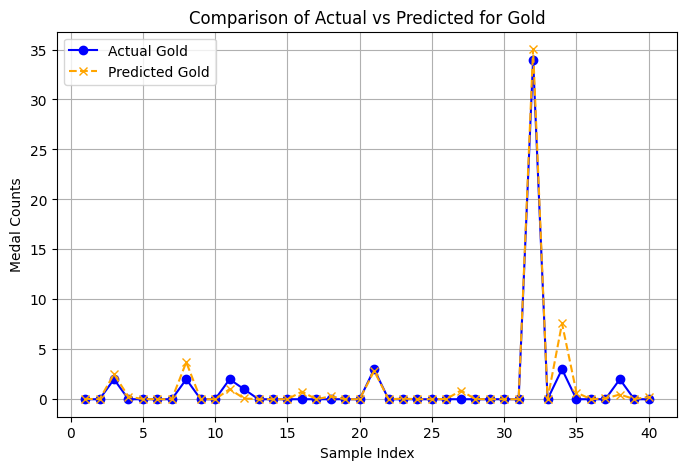

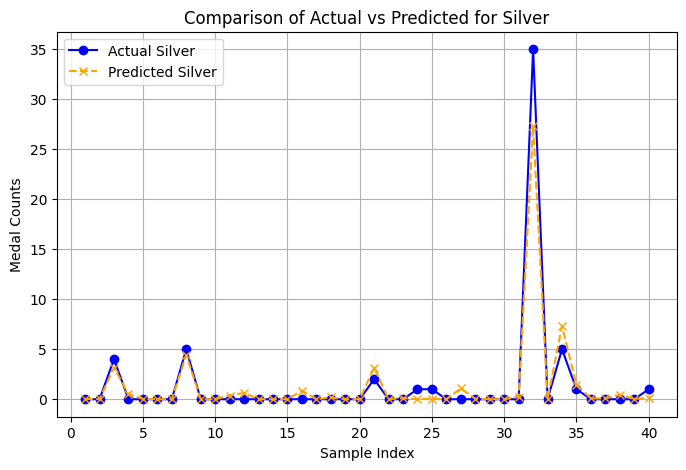

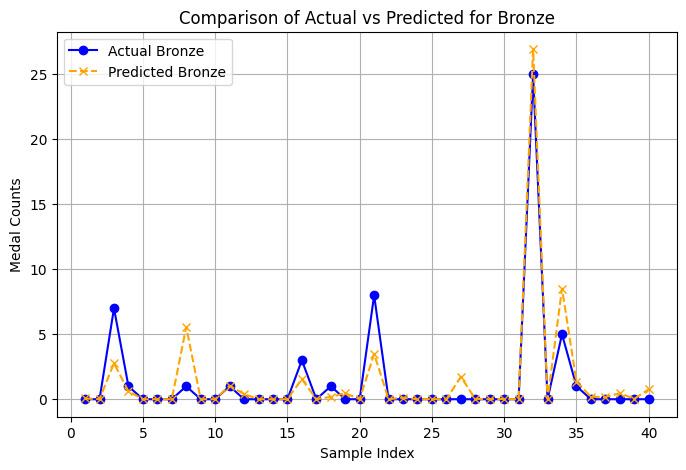

In [ ]:
import matplotlib.pyplot as plt

# Chọn 10 mẫu đầu tiên từ tập kiểm tra để trực quan hóa
y_actual = y_test.iloc[:40].values  # Giá trị thực tế
y_pred = y_pred_rf[:40]  # Giá trị dự đoán

# Tạo các biểu đồ đường riêng cho từng loại huy chương
categories = ['Gold', 'Silver', 'Bronze']
x = range(1, len(y_actual) + 1)  # Số thứ tự mẫu

for i, category in enumerate(categories):
    plt.figure(figsize=(8, 5))
    plt.plot(x, y_actual[:, i], marker='o', label=f'Actual {category}', color='blue')
    plt.plot(x, y_pred[:, i], marker='x', linestyle='--', label=f'Predicted {category}', color='orange')
    plt.xlabel('Sample Index')
    plt.ylabel('Medal Counts')
    plt.title(f'Comparison of Actual vs Predicted for {category}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

# Khởi tạo và bọc MultiOutputRegressor
model = MultiOutputRegressor(lgb.LGBMRegressor())
model.fit(X_train, y_train)

# Lấy feature importances cho từng đầu ra
for i, estimator in enumerate(model.estimators_):
    print(f"Feature importances for output {i}:")
    print(estimator.feature_importances_)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 2966, number of used features: 56
[LightGBM] [Info] Start training from score 1.533378
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 2966, number of used features: 56
[LightGBM] [Info] Start training from score 1.545853
[LightGBM] [Warning] Found whi

In [ ]:
import numpy as np

# Tính trung bình tầm quan trọng đặc trưng trên các đầu ra
feature_importances = np.mean([estimator.feature_importances_ for estimator in model.estimators_], axis=0)

# Hiển thị kết quả
features = X.columns if hasattr(X, 'columns') else range(len(feature_importances))
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


                                Feature  Importance
5         Athlete_Ratio_Among_Countries  691.666667
8    Medal_Winning_Percentage_Per_Event  465.000000
3                           Medal_Score  278.000000
7             Total_Events_Participated  252.666667
4                          Medals_lag_1  245.666667
..                                  ...         ...
112                         NOC_GER/USA    0.000000
113                             NOC_GHA    0.000000
114                             NOC_GIN    0.000000
115                             NOC_GMB    0.000000
275                             NOC_ZWE    0.000000

[276 rows x 2 columns]


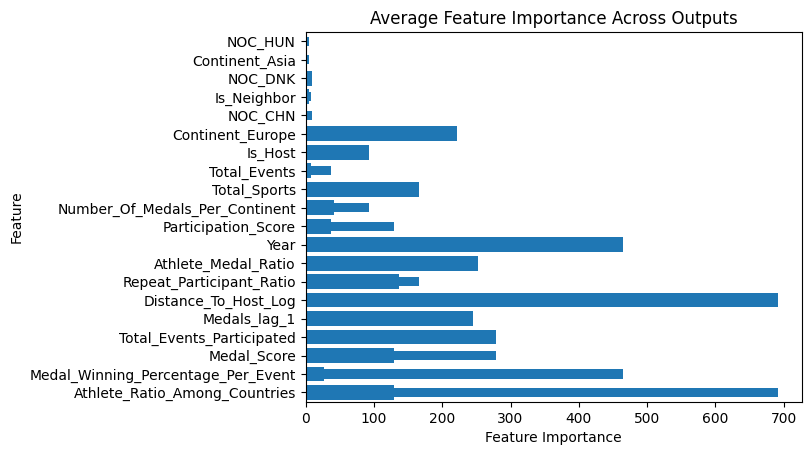

In [ ]:
import matplotlib.pyplot as plt
importance_df.sort_values(by="Importance", ascending=False).head(20).plot(
    kind="barh", x="Feature", y="Importance", legend=False)
# Vẽ biểu đồ
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Average Feature Importance Across Outputs')
plt.show()


In [ ]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (2966, 276)
Shape of y_train: (2966, 3)
Shape of X_test: (742, 276)
Shape of y_test: (742, 3)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

# Khởi tạo các mô hình base
lgb_model = LGBMRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)



# Tạo các mô hình thành phần
estimators = [
    ('lightgbm', lgb_model),
    ('xgboost', xgb_model),
    ('random_forest', rf_model)
]

# Mô hình meta
meta_model = Ridge()

# Tạo Stacking Regressor với Multi-Output
stacking_model = MultiOutputRegressor(
    StackingRegressor(
        estimators=estimators,
        final_estimator=meta_model,
        cv=5  # Cross-validation
    )
)

# Huấn luyện
stacking_model.fit(X_train, y_train)

# Dự đoán
stacking_pred = stacking_model.predict(X_test)




[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 2966, number of used features: 56
[LightGBM] [Info] Start training from score 1.533378
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2013
[LightGBM] [Info] Number of data points in the train set: 2372, number of used features: 42
[LightGBM] [Info] Start training from score 1.525295
[LightGBM] [Warning] Found whi

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Tính các chỉ số
mae = mean_absolute_error(y_test, stacking_pred, multioutput='raw_values')
mse = mean_squared_error(y_test, stacking_pred, multioutput='raw_values')
rmse = np.sqrt(mse)
r2 = r2_score(y_test, stacking_pred, multioutput='raw_values')
# Hiển thị kết quả
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): [0.64481804 0.64475952 0.68808346]
Mean Squared Error (MSE): [2.38899171 2.15063711 2.29646666]
Root Mean Squared Error (RMSE): [1.54563635 1.46650507 1.51540973]
R-squared (R²): [0.91692828 0.90021751 0.89317924]


Dựa trên các chỉ số đánh giá mà bạn cung cấp, đây là nhận xét:

---

### **1. Mean Absolute Error (MAE):**
- Giá trị **MAE**:
  - **Gold:** 0.645
  - **Silver:** 0.645
  - **Bronze:** 0.688

#### **Nhận xét:**
- **MAE** cho biết sai số trung bình tuyệt đối giữa giá trị dự đoán và thực tế.
- Các giá trị MAE dưới 1 cho thấy mô hình có khả năng dự đoán khá tốt, với sai số trung bình ít hơn 1 huy chương cho mỗi quốc gia ở mỗi loại huy chương.
- Huy chương **Bronze** có sai số cao hơn một chút so với **Gold** và **Silver**, cho thấy dự đoán về huy chương đồng hơi kém chính xác hơn.

---

### **2. Mean Squared Error (MSE):**
- Giá trị **MSE**:
  - **Gold:** 2.389
  - **Silver:** 2.151
  - **Bronze:** 2.296

#### **Nhận xét:**
- **MSE** phóng đại các sai số lớn do tính bình phương, nhưng các giá trị này tương đối thấp. Điều này cho thấy mô hình không có nhiều sai số lớn.
- Huy chương **Silver** có giá trị MSE thấp nhất, nghĩa là dự đoán về huy chương bạc chính xác hơn so với **Gold** và **Bronze**.

---

### **3. Root Mean Squared Error (RMSE):**
- Giá trị **RMSE**:
  - **Gold:** 1.546
  - **Silver:** 1.467
  - **Bronze:** 1.515

#### **Nhận xét:**
- **RMSE** chuyển đổi MSE về cùng đơn vị với dữ liệu (số lượng huy chương).
- Sai số trung bình khoảng **1.5 huy chương** cho mỗi quốc gia trên mỗi loại huy chương. Điều này phù hợp với kết quả MAE và MSE.

---

### **4. R-squared (R²):**
- Giá trị **R²**:
  - **Gold:** 0.917
  - **Silver:** 0.900
  - **Bronze:** 0.893

#### **Nhận xét:**
- **R²** đo lường mức độ giải thích của mô hình với dữ liệu (giá trị từ 0 đến 1, càng gần 1 càng tốt).
- Mô hình đạt giá trị **R² > 0.89** cho tất cả các loại huy chương, cho thấy mô hình giải thích tốt hơn **89%** phương sai trong dữ liệu thực tế.
- **Gold** có giá trị **R² cao nhất (0.917)**, cho thấy dự đoán về huy chương vàng chính xác hơn các loại huy chương khác.

---

### **Tổng quan nhận xét:**
1. **Hiệu suất mô hình tốt:**
   - MAE, MSE, và RMSE đều cho thấy sai số thấp và nằm trong phạm vi chấp nhận được.
   - R² cho thấy mô hình có khả năng giải thích tốt mối quan hệ giữa các đặc trưng và số lượng huy chương.

2. **Điểm cải thiện:**
   - **Bronze:** Dự đoán cho huy chương đồng có sai số cao hơn một chút (MAE và RMSE cao hơn so với Gold và Silver).
   - Có thể cần xem xét thêm các feature ảnh hưởng đến huy chương đồng để cải thiện độ chính xác.

3. **Kết luận:**
   - Mô hình hiện tại đủ mạnh để dự đoán số lượng huy chương, nhưng có thể tập trung cải thiện một chút vào các quốc gia/các feature ảnh hưởng đến huy chương đồng để giảm sai số.

Nếu bạn cần phân tích sâu hơn hoặc điều chỉnh mô hình để cải thiện kết quả, hãy cho tôi biết!

In [ ]:
print(noc_columns)

['NOC_AAM', 'NOC_AFG', 'NOC_AGO', 'NOC_AHO', 'NOC_ALB', 'NOC_AND', 'NOC_ANZ', 'NOC_ARE', 'NOC_ARG', 'NOC_ARM', 'NOC_ARU', 'NOC_ASA', 'NOC_ATG', 'NOC_AUS', 'NOC_AUS/GBR', 'NOC_AUT', 'NOC_AZE', 'NOC_BDI', 'NOC_BEL', 'NOC_BEN', 'NOC_BER', 'NOC_BFA', 'NOC_BGD', 'NOC_BGR', 'NOC_BHR', 'NOC_BHS', 'NOC_BIH', 'NOC_BLR', 'NOC_BLZ', 'NOC_BOH', 'NOC_BOL', 'NOC_BRA', 'NOC_BRB', 'NOC_BRN', 'NOC_BRU', 'NOC_BTN', 'NOC_BUL', 'NOC_BWA', 'NOC_BWI', 'NOC_CAF', 'NOC_CAN', 'NOC_CAY', 'NOC_CEY', 'NOC_CGO', 'NOC_CHE', 'NOC_CHL', 'NOC_CHN', 'NOC_CIV', 'NOC_CMR', 'NOC_COD', 'NOC_COK', 'NOC_COL', 'NOC_COM', 'NOC_CPV', 'NOC_CRI', 'NOC_CUB', 'NOC_CYP', 'NOC_CZE', 'NOC_DEN', 'NOC_DEN/SWE', 'NOC_DEU', 'NOC_DJI', 'NOC_DMA', 'NOC_DNK', 'NOC_DOM', 'NOC_DZA', 'NOC_ECU', 'NOC_EGY', 'NOC_ENG', 'NOC_ERI', 'NOC_ESP', 'NOC_EST', 'NOC_ETH', 'NOC_EUG', 'NOC_EUN', 'NOC_FIN', 'NOC_FJI', 'NOC_FOR', 'NOC_FRA', 'NOC_FRA/GBR', 'NOC_FRG', 'NOC_FRY', 'NOC_FSM', 'NOC_GAB', 'NOC_GAM', 'NOC_GBR', 'NOC_GBR/GER', 'NOC_GBS', 'NOC_GDR', 'NOC

In [ ]:
# Danh sách 5 năm gần nhất cần sử dụng
recent_years = [2024, 2020, 2016, 2012, 2008]

# Lọc các NOC tham gia đầy đủ 5 năm gần nhất
valid_noc = []
for noc in noc_columns:
    noc_data = final_df[final_df[noc] == 1]  # Lọc dữ liệu của NOC
    if set(recent_years).issubset(set(noc_data['Year'])):  # Kiểm tra đủ 5 năm gần nhất
        valid_noc.append(noc)

print(f"Số NOC tham gia đủ 5 năm gần nhất: {len(valid_noc)}")
print(f"Danh sách NOC hợp lệ: {valid_noc}")


Số NOC tham gia đủ 5 năm gần nhất: 193
Danh sách NOC hợp lệ: ['NOC_AFG', 'NOC_AGO', 'NOC_ALB', 'NOC_AND', 'NOC_ARG', 'NOC_ARM', 'NOC_ARU', 'NOC_ASA', 'NOC_ATG', 'NOC_AUS', 'NOC_AUT', 'NOC_AZE', 'NOC_BDI', 'NOC_BEL', 'NOC_BEN', 'NOC_BER', 'NOC_BFA', 'NOC_BGD', 'NOC_BGR', 'NOC_BHR', 'NOC_BHS', 'NOC_BIH', 'NOC_BLZ', 'NOC_BOL', 'NOC_BRA', 'NOC_BRB', 'NOC_BTN', 'NOC_BWA', 'NOC_CAF', 'NOC_CAN', 'NOC_CAY', 'NOC_CGO', 'NOC_CHE', 'NOC_CHL', 'NOC_CHN', 'NOC_CIV', 'NOC_CMR', 'NOC_COD', 'NOC_COK', 'NOC_COL', 'NOC_COM', 'NOC_CPV', 'NOC_CRI', 'NOC_CUB', 'NOC_CYP', 'NOC_CZE', 'NOC_DEU', 'NOC_DJI', 'NOC_DMA', 'NOC_DNK', 'NOC_DOM', 'NOC_DZA', 'NOC_ECU', 'NOC_EGY', 'NOC_ERI', 'NOC_ESP', 'NOC_EST', 'NOC_ETH', 'NOC_FIN', 'NOC_FJI', 'NOC_FRA', 'NOC_FSM', 'NOC_GAB', 'NOC_GBR', 'NOC_GEO', 'NOC_GHA', 'NOC_GIN', 'NOC_GNQ', 'NOC_GRC', 'NOC_GRD', 'NOC_GTM', 'NOC_GUM', 'NOC_GUY', 'NOC_HKG', 'NOC_HND', 'NOC_HRV', 'NOC_HTI', 'NOC_HUN', 'NOC_IDN', 'NOC_IND', 'NOC_IRL', 'NOC_IRN', 'NOC_IRQ', 'NOC_ISL', 'NOC_ISR', 'NO

In [ ]:
import numpy as np

# Hàm chuẩn bị dữ liệu chuỗi thời gian cho LSTM
def prepare_lstm_data(data, noc_columns, valid_noc, lookback=5):
    X, y = [], []
    for noc in valid_noc:
        noc_data = data[data[noc] == 1].sort_values(by='Year')  # Lọc dữ liệu NOC
        for i in range(lookback, len(noc_data)):
            X.append(noc_data.iloc[i-lookback:i].drop(columns=['Year', 'Gold', 'Silver', 'Bronze']).values)
            y.append(noc_data.iloc[i].drop(columns=['Year', 'Gold', 'Silver', 'Bronze']).values)
    return np.array(X), np.array(y)

# Chuẩn bị dữ liệu
lookback = 5
X_lstm, y_lstm = prepare_lstm_data(final_df, noc_columns, valid_noc, lookback)

# Kiểm tra kích thước dữ liệu
print("X_lstm shape:", X_lstm.shape)
print("y_lstm shape:", y_lstm.shape)


X_lstm shape: (2377, 5, 275)
y_lstm shape: (2377, 279)


In [ ]:
import numpy as np

def linear_extrapolation(data, lookback=5):
    """
    Ngoại suy tuyến tính cho các feature liên tục.
    :param data: Mảng giá trị của feature theo thời gian (cột là feature).
    :param lookback: Số năm gần nhất sử dụng cho ngoại suy.
    :return: Giá trị dự đoán cho năm tiếp theo.
    """
    # Lấy các giá trị cuối cùng (lookback năm)
    recent_data = data[-lookback:]
    years = np.arange(lookback)

    # Ngoại suy tuyến tính từng feature
    predictions = []
    for feature in recent_data.T:  # Duyệt qua từng cột (feature)
        coefficients = np.polyfit(years, feature, 1)  # Hồi quy bậc 1 (tuyến tính)
        next_year_value = np.polyval(coefficients, lookback)  # Dự đoán năm tiếp theo
        predictions.append(next_year_value)

    return np.array(predictions)


In [ ]:
# Danh sách các feature cần ngoại suy (ngoại trừ NOC và Continent)
extrapolated_features = [col for col in final_df.columns
                         if col not in ['Year', 'Gold', 'Silver', 'Bronze'] + noc_columns + [
                             'Continent_Africa', 'Continent_Asia',
                             'Continent_Europe', 'Continent_North America',
                             'Continent_Oceania', 'Continent_South America']]

future_predictions = []

# Áp dụng ngoại suy cho từng quốc gia
for noc in valid_noc:
    noc_data = final_df[final_df[noc] == 1].sort_values(by='Year')  # Lọc dữ liệu theo NOC
    feature_values = noc_data[extrapolated_features].values  # Chỉ lấy các feature liên tục

    # Ngoại suy các feature cho năm tiếp theo
    prediction = linear_extrapolation(feature_values, lookback=5)

    # Tạo bản ghi cho năm 2028
    future_record = {col: val for col, val in zip(extrapolated_features, prediction)}
    future_record.update({noc: 1})  # Giữ NOC này bằng 1 (one-hot encoding)
    future_record.update({col: 0 for col in noc_columns if col != noc})  # Các NOC khác = 0
    future_record.update({
        'Year': 2028,
        'Continent_Africa': noc_data['Continent_Africa'].iloc[0],  # Giữ nguyên Continent
        'Continent_Asia': noc_data['Continent_Asia'].iloc[0],
        'Continent_Europe': noc_data['Continent_Europe'].iloc[0],
        'Continent_North America': noc_data['Continent_North America'].iloc[0],
        'Continent_Oceania': noc_data['Continent_Oceania'].iloc[0],
        'Continent_South America': noc_data['Continent_South America'].iloc[0]
    })

    future_predictions.append(future_record)

# Chuyển đổi sang DataFrame
future_df = pd.DataFrame(future_predictions)

print(future_df)


     Is_Host  Participation_Score  Medal_Score  Medals_lag_1  \
0        0.0             2.333285     0.868789           0.2   
1        0.0             2.193963     0.300000           0.0   
2        0.0             2.159158     0.300000           0.0   
3        0.0             2.255623     0.300000           0.0   
4        0.0             2.518335     1.213962          -1.4   
..       ...                  ...          ...           ...   
188      0.0             2.193963     0.374221          -0.4   
189      0.0             2.193963     0.300000           0.0   
190      0.0             2.436417    11.057543          28.0   
191      0.0             2.309035     0.306060           0.0   
192      0.0             2.309035    -0.439917          -6.6   

     Athlete_Ratio_Among_Countries  Athlete_Medal_Ratio  \
0                         0.000421             0.050000   
1                         0.001197             0.000000   
2                         0.000472             0.00000

In [ ]:
# Các feature đã sử dụng để huấn luyện stacking_model
stacking_features = X_train.columns

# Lọc và sắp xếp dữ liệu đầu vào theo đúng thứ tự feature
future_input = future_df[stacking_features]


In [ ]:
import numpy as np

def bayesian_bootstrap(model, X, n_bootstrap=1000, alpha=0.05):
    """
    Bayesian Bootstrap để tính khoảng tin cậy.
    :param model: Mô hình đã huấn luyện (stacking_model).
    :param X: Dữ liệu đầu vào (future_input).
    :param n_bootstrap: Số lần lặp Bootstrap.
    :param alpha: Mức ý nghĩa (0.05 cho 95% CI).
    :return: Lower, Upper bounds cho từng dự đoán.
    """
    predictions = []
    n_samples = X.shape[0]

    for i in range(n_bootstrap):
        # Tạo trọng số ngẫu nhiên từ phân phối Dirichlet
        weights = np.random.dirichlet(np.ones(n_samples))

        # Tính dự đoán có trọng số
        weighted_X = X * weights[:, np.newaxis]
        preds = model.predict(weighted_X)
        predictions.append(preds)

    predictions = np.array(predictions)

    # Tính khoảng tin cậy
    lower_bound = np.percentile(predictions, 100 * (alpha / 2), axis=0)
    upper_bound = np.percentile(predictions, 100 * (1 - alpha / 2), axis=0)

    return lower_bound, upper_bound


In [ ]:
# Dự đoán số huy chương bằng stacking_model
future_predictions = stacking_model.predict(future_input)

# Áp dụng Bayesian Bootstrap để tính khoảng tin cậy
lower, upper = bayesian_bootstrap(stacking_model, future_input, n_bootstrap=1000)

# Gắn kết quả vào future_df
future_df[['Gold', 'Silver', 'Bronze']] = future_predictions
future_df['Gold_CI_Lower'], future_df['Gold_CI_Upper'] = lower[:, 0], upper[:, 0]
future_df['Silver_CI_Lower'], future_df['Silver_CI_Upper'] = lower[:, 1], upper[:, 1]
future_df['Bronze_CI_Lower'], future_df['Bronze_CI_Upper'] = lower[:, 2], upper[:, 2]

# Tính tổng số huy chương và sắp xếp
future_df['Total_Medals'] = future_df['Gold'] + future_df['Silver'] + future_df['Bronze']
future_df = future_df.sort_values(by='Total_Medals', ascending=False)




In [ ]:
# Hiển thị kết quả
print(future_df[['Year', 'Gold', 'Gold_CI_Lower', 'Gold_CI_Upper',
                 'Silver', 'Silver_CI_Lower', 'Silver_CI_Upper',
                 'Bronze', 'Bronze_CI_Lower', 'Bronze_CI_Upper',
                 'Total_Medals']])

     Year       Gold  Gold_CI_Lower  Gold_CI_Upper     Silver  \
141  2028  42.219007       0.119404       3.109091  41.845222   
64   2028  39.312529      -0.078823       0.359132  31.574335   
145  2028  23.422011      -0.184452       0.205306  26.566368   
125  2028  26.379678       1.438580       1.791683  18.903071   
29   2028  17.989235      -0.298124       0.109622  14.857474   
..    ...        ...            ...            ...        ...   
41   2028  -0.075587       0.109622       0.109622  -0.105541   
46   2028  -0.076499       0.109622       0.109622  -0.096646   
172  2028  -0.094802       0.109622       0.109622  -0.099301   
49   2028  -0.075658       0.109622       0.109622  -0.095444   
89   2028  -0.080260       0.109622       0.109622  -0.101360   

     Silver_CI_Lower  Silver_CI_Upper     Bronze  Bronze_CI_Lower  \
141        -0.480125         3.361231  37.144841         0.065963   
64         -0.114216         1.150693  24.814494        -0.029548   
145        -

In [ ]:
# Tính tổng số huy chương (Gold + Silver + Bronze)
future_df['Total_Medals'] = future_df['Gold'] + future_df['Silver'] + future_df['Bronze']

# Sắp xếp theo tổng số huy chương (Total_Medals) từ cao đến thấp
sorted_future_df = future_df.sort_values(by='Total_Medals', ascending=False)

# Hiển thị kết quả
print(sorted_future_df[['Year', 'Gold', 'Silver', 'Bronze', 'Total_Medals'] + noc_columns])




     Year       Gold     Silver     Bronze  Total_Medals  NOC_AAM  NOC_AFG  \
141  2028  42.219007  41.845222  37.144841    121.209070        0        0   
64   2028  39.312529  31.574335  24.814494     95.701359        0        0   
145  2028  23.422011  26.566368  24.195342     74.183721        0        0   
125  2028  26.379678  18.903071  20.294357     65.577106        0        0   
29   2028  17.989235  14.857474  17.505091     50.351800        0        0   
..    ...        ...        ...        ...           ...      ...      ...   
41   2028  -0.075587  -0.105541  -0.036397     -0.217524        0        0   
46   2028  -0.076499  -0.096646  -0.050074     -0.223219        0        0   
172  2028  -0.094802  -0.099301  -0.029943     -0.224046        0        0   
49   2028  -0.075658  -0.095444  -0.056945     -0.228046        0        0   
89   2028  -0.080260  -0.101360  -0.049567     -0.231186        0        0   

     NOC_AGO  NOC_AHO  NOC_ALB  ...  NOC_VIN  NOC_VIR  NOC_VNM 

                                Feature    LightGBM     XGBoost  RandomForest  \
5         Athlete_Ratio_Among_Countries  691.666667  393.000000      0.520780   
8    Medal_Winning_Percentage_Per_Event  465.000000  195.000000      0.228441   
0                                  Year  129.000000  506.000000      0.010853   
3                           Medal_Score  278.000000  246.000000      0.026399   
7             Total_Events_Participated  252.666667  158.666667      0.079433   
..                                  ...         ...         ...           ...   
159                             NOC_LIE    0.000000    0.000000      0.000000   
160                             NOC_LKA    0.000000    0.000000      0.000000   
209                             NOC_PRY    0.000000    0.000000      0.000000   
161                             NOC_LSO    0.000000    0.000000      0.000000   
180                             NOC_MRI    0.000000    0.000000      0.000000   

        Average  
5    361.

<Figure size 1000x600 with 0 Axes>

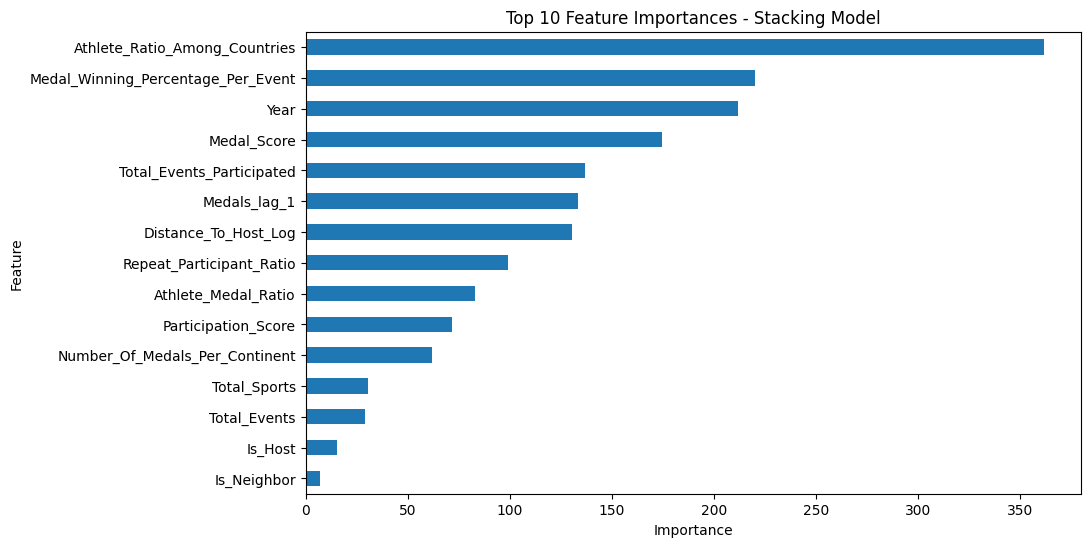

In [ ]:
import pandas as pd
import numpy as np

# Khởi tạo dictionary để lưu tầm quan trọng
feature_importances = {
    'LightGBM': [],
    'XGBoost': [],
    'RandomForest': []
}

# Lặp qua từng output (Gold, Silver, Bronze)
for i, estimator in enumerate(stacking_model.estimators_):
    # LightGBM
    lgb_importances = estimator.named_estimators_['lightgbm'].feature_importances_
    feature_importances['LightGBM'].append(lgb_importances)

    # XGBoost
    xgb_importances = estimator.named_estimators_['xgboost'].get_booster().get_score(importance_type='weight')
    xgb_importances = np.array([xgb_importances.get(f, 0) for f in X_train.columns])
    feature_importances['XGBoost'].append(xgb_importances)

    # Random Forest
    rf_importances = estimator.named_estimators_['random_forest'].feature_importances_
    feature_importances['RandomForest'].append(rf_importances)

# Tính trung bình tầm quan trọng cho mỗi base model
average_importances = {}
for model_name, importances in feature_importances.items():
    average_importances[model_name] = np.mean(importances, axis=0)

# Kết hợp tầm quan trọng của tất cả các base model
combined_average_importances = np.mean(list(average_importances.values()), axis=0)

# Tạo DataFrame kết quả
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'LightGBM': average_importances['LightGBM'],
    'XGBoost': average_importances['XGBoost'],
    'RandomForest': average_importances['RandomForest'],
    'Average': combined_average_importances
}).sort_values(by='Average', ascending=False)

# Hiển thị kết quả
print(feature_importances_df)

# Vẽ biểu đồ
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
feature_importances_df.head(15).plot(
    kind='barh', x='Feature', y='Average', legend=False, figsize=(10, 6))
plt.title("Top 10 Feature Importances - Stacking Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# Danh sách cột chứa mã hóa OneHot của NOC
noc_columns = [col for col in final_df.columns if col.startswith('NOC_')]

# Lấy danh sách feature quan trọng nhất
top_features = feature_importances_df.head(5)['Feature'].tolist()

# Tạo DataFrame lưu trữ kết quả
improvement_df = pd.DataFrame()

for noc in noc_columns:
    # Dữ liệu cho quốc gia tương ứng (NOC)
    noc_data_2024 = final_df[(final_df['Year'] == 2024) & (final_df[noc] == 1)]
    noc_data_2028 = future_df[(future_df[noc] == 1)]

    # Tính trung bình của các feature quan trọng
    avg_2024 = noc_data_2024[top_features].mean()
    avg_2028 = noc_data_2028[top_features].mean()

    # Tính sự thay đổi giữa hai năm
    improvement_df[noc] = avg_2028 - avg_2024

# Tính tổng điểm cải thiện
improvement_df['Improvement_Score'] = improvement_df.sum(axis=0)

# Chuyển đổi tên cột (NOC) thành chỉ mục
improvement_df = improvement_df.T.reset_index()
improvement_df.columns = top_features + ['Improvement_Score']

# Sắp xếp theo điểm cải thiện
improved_countries = improvement_df.sort_values(by='Improvement_Score', ascending=False).head(10)

# In kết quả
print("Các quốc gia có khả năng cải thiện nhất:")
print(improved_countries[['Improvement_Score'] + top_features])


<ipython-input-83-9f6d46ce16b2>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  improvement_df[noc] = avg_2028 - avg_2024
<ipython-input-83-9f6d46ce16b2>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  improvement_df[noc] = avg_2028 - avg_2024
<ipython-input-83-9f6d46ce16b2>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

Các quốc gia có khả năng cải thiện nhất:
     Improvement_Score Athlete_Ratio_Among_Countries  \
122               26.0                       NOC_JPN   
103               13.1                       NOC_HKG   
231               12.4                       NOC_TUN   
112               11.8                       NOC_IRL   
67                10.7                       NOC_EGY   
116               10.6                       NOC_ISR   
229                9.9                       NOC_TPE   
110                9.3                       NOC_IND   
16                 9.2                       NOC_AZE   
189                8.9                       NOC_PUR   

     Medal_Winning_Percentage_Per_Event      Year  Medal_Score  \
122                            0.024285 -0.187800          4.0   
103                            0.000514  5.464286          4.0   
231                            0.001421 -0.820941          4.0   
112                            0.001393 -1.716624          4.0   
67          

<ipython-input-83-9f6d46ce16b2>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  improvement_df[noc] = avg_2028 - avg_2024
<ipython-input-83-9f6d46ce16b2>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  improvement_df['Improvement_Score'] = improvement_df.sum(axis=0)


In [ ]:
# 1. Chuẩn bị dữ liệu 2024 và 2028
# Lọc dữ liệu năm 2024 và 2028
data_2024 = final_df[final_df['Year'] == 2024]
data_2028 = future_df

# Tính tổng số huy chương cho từng quốc gia
data_2024['Total_2024'] = data_2024['Gold'] + data_2024['Silver'] + data_2024['Bronze']
data_2028['Total_2028'] = data_2028['Gold'] + data_2028['Silver'] + data_2028['Bronze']

# Danh sách các cột NOC (đã mã hóa OneHot)
noc_columns = [col for col in final_df.columns if col.startswith('NOC_')]

# Tổng số huy chương theo NOC
total_2024 = {}
total_2028 = {}

for noc in noc_columns:
    # Tính tổng huy chương năm 2024 và 2028 cho từng NOC
    total_2024[noc] = data_2024[data_2024[noc] == 1]['Total_2024'].sum()
    total_2028[noc] = data_2028[data_2028[noc] == 1]['Total_2028'].sum()

# Tạo DataFrame so sánh
comparison_df = pd.DataFrame({
    'NOC': noc_columns,
    'Total_2024': [total_2024[noc] for noc in noc_columns],
    'Total_2028': [total_2028[noc] for noc in noc_columns]
})

# Tính chênh lệch
comparison_df['Difference'] = comparison_df['Total_2028'] - comparison_df['Total_2024']

# Quốc gia có kết quả kém hơn
worse_countries = comparison_df[comparison_df['Difference'] < 0].sort_values(by='Difference').head(10)



# Kết quả
print("Các quốc gia có kết quả kém hơn năm 2024:")
print(worse_countries[['NOC', 'Total_2024', 'Total_2028', 'Difference']])


<ipython-input-85-202a6f1dd581>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2024['Total_2024'] = data_2024['Gold'] + data_2024['Silver'] + data_2024['Bronze']


Các quốc gia có kết quả kém hơn năm 2024:
         NOC  Total_2024  Total_2028  Difference
241  NOC_USA         126   -0.183338 -126.183338
46   NOC_CHN          91   -0.177230  -91.177230
85   NOC_GBR          65    1.254384  -63.745616
78   NOC_FRA          64    3.681942  -60.318058
13   NOC_AUS          53    3.436298  -49.563702
122  NOC_JPN          45   -0.231186  -45.231186
118  NOC_ITA          40   -0.199335  -40.199335
172  NOC_NLD          34   -0.168549  -34.168549
60   NOC_DEU          33   -0.223219  -33.223219
129  NOC_KOR          32    0.558227  -31.441773


In [ ]:
import numpy as np
import pandas as pd

# 1. Xác định các quốc gia chưa từng giành huy chương trong lịch sử
# Tính tổng số huy chương trong lịch sử
final_df['Total_Historical'] = final_df['Gold'] + final_df['Silver'] + final_df['Bronze']

# Lọc các quốc gia chưa từng giành huy chương (tổng = 0)
noc_columns = [col for col in final_df.columns if col.startswith('NOC_')]
noc_no_medals = []
for noc in noc_columns:
    if final_df[final_df[noc] == 1]['Total_Historical'].sum() == 0:
        noc_no_medals.append(noc)

print(f"Số quốc gia chưa từng giành huy chương: {len(noc_no_medals)}")

# 2. Kiểm tra dữ liệu năm 2028
# Lọc dữ liệu năm 2028 cho các quốc gia chưa từng giành huy chương
future_df_2028 = future_df[future_df[noc_no_medals].sum(axis=1) > 0]

# Tính tổng số huy chương dự đoán năm 2028
future_df_2028['Total_Predicted'] = future_df_2028['Gold'] + future_df_2028['Silver'] + future_df_2028['Bronze']

# Lọc các quốc gia có tổng số huy chương dự đoán > 0
countries_with_medals = future_df_2028[future_df_2028['Total_Predicted'] > 0][noc_columns]
countries_with_medals['Total_Predicted'] = future_df_2028[future_df_2028['Total_Predicted'] > 0]['Total_Predicted']

# Thêm khoảng tin cậy cho từng dự đoán
countries_with_medals['Gold_CI_Lower'] = future_df_2028[future_df_2028['Total_Predicted'] > 0]['Gold_CI_Lower']
countries_with_medals['Gold_CI_Upper'] = future_df_2028[future_df_2028['Total_Predicted'] > 0]['Gold_CI_Upper']
countries_with_medals['Silver_CI_Lower'] = future_df_2028[future_df_2028['Total_Predicted'] > 0]['Silver_CI_Lower']
countries_with_medals['Silver_CI_Upper'] = future_df_2028[future_df_2028['Total_Predicted'] > 0]['Silver_CI_Upper']
countries_with_medals['Bronze_CI_Lower'] = future_df_2028[future_df_2028['Total_Predicted'] > 0]['Bronze_CI_Lower']
countries_with_medals['Bronze_CI_Upper'] = future_df_2028[future_df_2028['Total_Predicted'] > 0]['Bronze_CI_Upper']

# Tính tổng khoảng tin cậy (lower, upper) cho từng quốc gia
countries_with_medals['Total_CI_Lower'] = (countries_with_medals['Gold_CI_Lower'] +
                                           countries_with_medals['Silver_CI_Lower'] +
                                           countries_with_medals['Bronze_CI_Lower'])

countries_with_medals['Total_CI_Upper'] = (countries_with_medals['Gold_CI_Upper'] +
                                           countries_with_medals['Silver_CI_Upper'] +
                                           countries_with_medals['Bronze_CI_Upper'])

countries_with_medals['Total_CI_Avg'] = (countries_with_medals['Total_CI_Lower'] +
                                         countries_with_medals['Total_CI_Upper']) / 2

# Chuyển từ mã hóa OneHot về danh sách quốc gia
noc_results = []
for idx, row in countries_with_medals.iterrows():
    # Lấy quốc gia từ các cột mã hóa OneHot
    noc = [noc for noc in noc_columns if row[noc] == 1]
    if noc:
        noc_results.append({
            'NOC': noc[0],
            'Total_Predicted': row['Total_Predicted'],
            'Total_CI_Lower': row['Total_CI_Lower'],
            'Total_CI_Upper': row['Total_CI_Upper'],
            'Total_CI_Avg': row['Total_CI_Avg']
        })

# Tạo DataFrame kết quả
results_df = pd.DataFrame(noc_results)

# Sắp xếp theo tổng số huy chương và lấy top 10
top_countries = results_df.sort_values(by='Total_Predicted', ascending=False).head(10)

# Tính khoảng tin cậy trung bình
avg_ci_lower = results_df['Total_CI_Lower'].mean()
avg_ci_upper = results_df['Total_CI_Upper'].mean()
avg_ci_avg = results_df['Total_CI_Avg'].mean()

# Kết quả cuối cùng
print(f"Số quốc gia sẽ giành huy chương đầu tiên năm 2028: {len(results_df)}")
print(f"Các quốc gia sẽ giành huy chương đầu tiên năm 2028 cùng tổng số huy chương dự đoán và khoảng tin cậy:")
print(top_countries)

print("\nKhoảng tin cậy trung bình:")
print(f"Lower Bound (Trung bình): {avg_ci_lower}")
print(f"Upper Bound (Trung bình): {avg_ci_upper}")
print(f"Average Confidence Interval (Trung bình): {avg_ci_avg}")


Số quốc gia chưa từng giành huy chương: 97
Số quốc gia sẽ giành huy chương đầu tiên năm 2028: 33
Các quốc gia sẽ giành huy chương đầu tiên năm 2028 cùng tổng số huy chương dự đoán và khoảng tin cậy:
       NOC  Total_Predicted  Total_CI_Lower  Total_CI_Upper  Total_CI_Avg
0  NOC_PNG       121.209070       -0.294759       10.598329      5.151785
1  NOC_IVB        12.207321       -0.468496        1.817864      0.674684
2  NOC_KHM        11.318609       -0.468496        1.817864      0.674684
3  NOC_MLT        10.714909       -0.457910        1.828449      0.685269
4  NOC_SYC         9.728115       -0.468496        1.817864      0.674684
5  NOC_ARU         8.761320       -0.457257        1.828449      0.685596
6  NOC_STP         7.204498       -0.467589        1.817864      0.675137
7  NOC_TUV         7.165592       -0.452456        1.834051      0.690797
8  NOC_MLI         6.051007       -0.478238        1.808122      0.664942
9  NOC_SLB         4.539551       -0.462388        1.823466  

<ipython-input-104-d0950854d3ec>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_df_2028['Total_Predicted'] = future_df_2028['Gold'] + future_df_2028['Silver'] + future_df_2028['Bronze']


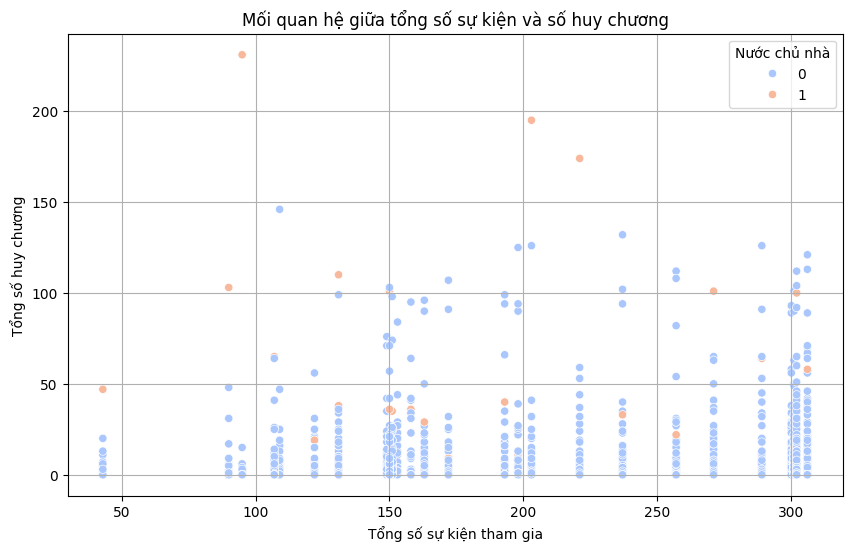

<ipython-input-105-1998fb573579>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_df, x='Is_Host', y='Total_Medals', palette='coolwarm')


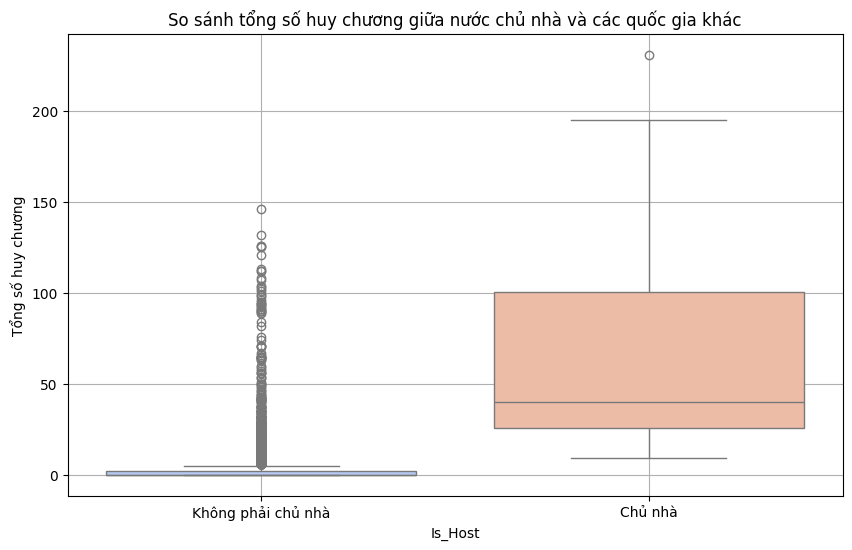

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Tổng số sự kiện mà mỗi quốc gia tham gia
final_df['Total_Events_Participated'] = final_df['Total_Events']
final_df['Total_Medals'] = final_df['Gold'] + final_df['Silver'] + final_df['Bronze']

# Phân tích mối quan hệ giữa sự kiện và số lượng huy chương
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=final_df['Total_Events_Participated'],
    y=final_df['Total_Medals'],
    hue=final_df['Is_Host'],
    palette='coolwarm'
)
plt.title("Mối quan hệ giữa tổng số sự kiện và số huy chương")
plt.xlabel("Tổng số sự kiện tham gia")
plt.ylabel("Tổng số huy chương")
plt.legend(title="Nước chủ nhà")
plt.grid(True)
plt.show()

# 2. Ảnh hưởng của nước chủ nhà
host_country_df = final_df[final_df['Is_Host'] == 1]
non_host_country_df = final_df[final_df['Is_Host'] == 0]

# So sánh tổng số huy chương của nước chủ nhà và các quốc gia khác
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_df, x='Is_Host', y='Total_Medals', palette='coolwarm')
plt.title("So sánh tổng số huy chương giữa nước chủ nhà và các quốc gia khác")
plt.xticks([0, 1], ['Không phải chủ nhà', 'Chủ nhà'])
plt.ylabel("Tổng số huy chương")
plt.grid(True)
plt.show()

# 3. Phân tích ảnh hưởng đến các môn thể thao được lựa chọn
# Giả sử chúng ta có cột 'Selected_Events_Host' thể hiện số lượng sự kiện được chọn bởi nước chủ nhà
if 'Selected_Events_Host' in final_df.columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='Selected_Events_Host',
        y='Total_Medals',
        data=host_country_df,
        palette='viridis'
    )
    plt.title("Ảnh hưởng của các sự kiện được nước chủ nhà chọn đến số huy chương")
    plt.xlabel("Số lượng sự kiện được nước chủ nhà chọn")
    plt.ylabel("Tổng số huy chương")
    plt.grid(True)
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# 1. Chuẩn bị dữ liệu
# Tính tổng số huy chương cho từng năm và từng môn thể thao
final_df['Total_Medals'] = final_df['Gold'] + final_df['Silver'] + final_df['Bronze']
sport_df = final_df.groupby(['Sport', 'Year']).agg({'Total_Medals': 'sum'}).reset_index()

# Lấy danh sách các cột mã hóa NOC
noc_columns = [col for col in final_df.columns if col.startswith('NOC_')]

# Thêm tổng số huy chương của từng quốc gia
for noc in noc_columns:
    sport_df[noc] = final_df.groupby(['Sport', 'Year'])[noc].sum().reset_index(drop=True)

# OneHotEncode các môn thể thao
sport_df = pd.get_dummies(sport_df, columns=['Sport'], drop_first=True)

# Tách dữ liệu
X = sport_df.drop(columns=['Year', 'Total_Medals'])
y = sport_df['Total_Medals']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Xây dựng mô hình XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# 3. Dự đoán và đánh giá
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# 4. Trích xuất mức độ quan trọng của từng môn thể thao và quốc gia
feature_importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Lọc các môn thể thao quan trọng nhất
sport_importances = importance_df[importance_df['Feature'].str.startswith('Sport_')]
top_sports = sport_importances.head(10)

print("Top 10 môn thể thao quan trọng nhất:")
print(top_sports)

# 5. Tính tỷ lệ đóng góp của từng quốc gia (dựa trên NOC)
noc_importances = importance_df[importance_df['Feature'].isin(noc_columns)]
noc_importances['Contribution (%)'] = (noc_importances['Importance'] / noc_importances['Importance'].sum()) * 100

print("\nTỷ lệ đóng góp của từng quốc gia vào tổng số huy chương:")
print(noc_importances.sort_values(by='Contribution (%)', ascending=False))

# 6. Tính tỷ lệ đóng góp của từng môn thể thao
predicted_medals = pd.DataFrame({
    'Sport': X_test.columns,
    'Predicted_Medals': y_pred
})
predicted_medals['Contribution (%)'] = (predicted_medals['Predicted_Medals'] / predicted_medals['Predicted_Medals'].sum()) * 100

print("\nTỷ lệ đóng góp của từng môn thể thao vào tổng số huy chương:")
print(predicted_medals.sort_values(by='Contribution (%)', ascending=False))


KeyError: 'Sport'